# WindyGridworld from the book "Reinforcement Learning an : Introduction (Sutton & Barto)"

## Useful libraries

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

## Creation of the environment

In [187]:
class WindyGridworld(gym.Env):

    def __init__(self, stochastic=False):
        self.stochastic = stochastic
        self.width = 10
        self.height = 7
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])
        self.action_space = spaces.Discrete(8)
        self.low = np.array([0, 0])
        self.high = np.array([self.height, self.width])
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
        self.actions_map = [
            (-1, -1), # ↖
            (-1, 0),  # ↑
            (-1, 1),  # ↗
            (0, -1),  # ←
            (0, 1),   # →
            (1, -1),  # ↙
            (1, 0),   # ↓
            (1, 1),   # ↘
        ]
        self.final_state = np.array([3, 7])
        self.stochastic_variation = np.array([-1, 0, 1])

    def step(self, action: int):
        """
        actions :

            (0)  (1)  (2)
                ↖ ↑ ↗
            (3) ←   → (4)
                ↙ ↓ ↘
            (5)  (6)  (7)

        """

        new_state = np.array(self.state)
        new_state += self.actions_map[action]  # The move
        
        if new_state[1] < 0 : new_state[1] = 0
        if new_state[1] >= self.width : new_state[1] = self.width-1

        variation = 0
        if self.stochastic and self.wind[self.state[1]] != 0:
            variation += np.random.choice(self.stochastic_variation)

        new_state[0] -= self.wind[self.state[1]] + variation # The wind

        if new_state[0] < 0 : new_state[0] = 0
        if new_state[0] >= self.height : new_state[0] = self.height-1
            
        self.state = np.array(new_state)

        done = (self.state == self.final_state).all()

        return np.array(self.state), -1, done, {}

    def reset(self):
        self.state = np.array([3, 0])
        return self.state

    def render(self):
        fig = plt.figure()
        img = np.tile(self.wind, (self.height, 1))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img, cmap='Blues', interpolation='nearest')
        ax.plot(self.final_state[1], self.final_state[0], 'og')
        ax.plot(self.state[1], self.state[0], 'ok')
        ax.set_xticks(np.arange(self.width))
        ax.set_xticks(np.arange(0.5, self.width), minor=True)
        ax.set_yticks(np.arange(self.height))
        ax.set_yticks(np.arange(0.5, self.height), minor=True)
        ax.grid(which='minor')
        
        plt.show()
    
    def render_policy(self, policy):
        # create the grid
        fig = plt.figure()
        img = np.tile(self.wind, (self.height, 1))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img, cmap='Blues', interpolation='nearest')
        ax.plot(self.final_state[1], self.final_state[0], 'og')
        ax.set_xticks(np.arange(self.width), labels=self.wind)
        ax.set_xticks(np.arange(0.5, self.width), minor=True)
        ax.set_yticks(np.arange(0.5, self.height), minor=True)
        ax.grid(which='minor')
        ax.set_yticks([])

        # plot the path
        state = tuple(self.reset())
        done = False
        nb_steps = 0
        while not done:
            nb_steps += 1
            new_state, _, done, _ = self.step(policy[state])
            ax.plot((state[1], new_state[1]), (state[0], new_state[0]))
            state = tuple(new_state)
            done = done or nb_steps > 20
        
        plt.show()
        if nb_steps > 20:
            print(f'The agent didnt reach the goal after 20 steps')
        else:
            print(f'End in {nb_steps} steps')

## Implementation of the Sarsa algorithm (On-policy TD Control)

In [188]:
class Sarsa(object):
    def learn(self, env, nb_episode, alpha=.5, eps=.1, gamma=1):
        self.actions = np.arange(env.action_space.n)
        self.states = []
        for x in range(env.height):
            for y in  range(env.width):
                self.states.append((x,y))
        self.states = np.array(self.states)
        self.Q = {tuple(s): np.random.rand(env.action_space.n) for s in self.states}
        self.Q[tuple(env.final_state)] = np.array([0] * env.action_space.n)
        self.policy = {tuple(s): np.argmax(self.Q[tuple(s)]) for s in self.states}
        timesteps = []
        nb_steps = 0
        for e in range(nb_episode):
            state = tuple(env.reset())
            if np.random.rand() < eps:
                action = env.action_space.sample()
            else:
                action = self.policy[state]
            done = False
            while not done:
                nb_steps += 1
                new_state, reward, done, _ = env.step(action)
                new_state = tuple(new_state)
                if np.random.rand() < eps:
                    new_action = env.action_space.sample()
                else:
                    new_action = self.policy[new_state]
                self.Q[state][action] += alpha * (reward + gamma * self.Q[new_state][new_action] - self.Q[state][action])
                self.policy[state] = np.argmax(self.Q[state])
                state = new_state
                action = new_action
            timesteps.append(nb_steps)
        return self.policy, timesteps

## Results for deterministic wind and King's Moves

In [189]:
env = WindyGridworld()
agent = Sarsa()
nb_episodes = 1000
learned_policy, timesteps = agent.learn(env, nb_episodes, alpha=0.1)

Text(0, 0.5, 'Episodes')

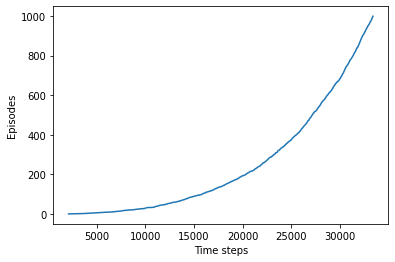

In [190]:
plt.plot(timesteps, list(range(nb_episodes)))
plt.xlabel('Time steps')
plt.ylabel('Episodes')

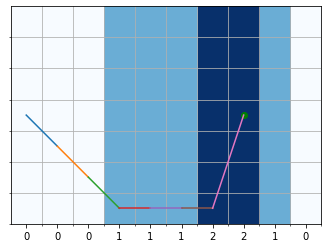

End in 7 steps


In [191]:
env.render_policy(learned_policy)

## Results for stochastic wind and King's Moves

In [251]:
env = WindyGridworld(True)
agent = Sarsa()
nb_episodes = 10000
learned_policy, timesteps = agent.learn(env, nb_episodes, alpha=0.05)

Text(0, 0.5, 'Episodes')

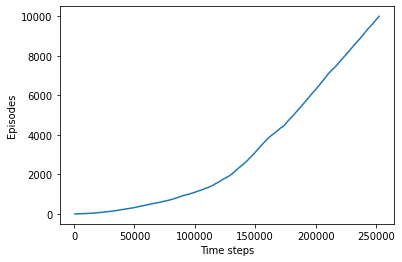

In [252]:
plt.plot(timesteps, list(range(nb_episodes)))
plt.xlabel('Time steps')
plt.ylabel('Episodes')

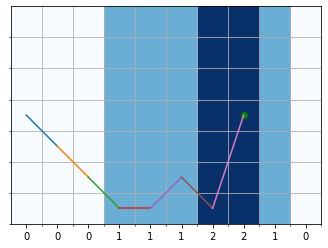

End in 7 steps


In [273]:
env.render_policy(learned_policy)